# Bonus: Sentiment Classifier counting neutral cases (multiclass)

This repeats the previous notebook for using 3 classes instead of 2 (we include the neutral cases).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import my_utils

Having already trained the language model, it is time to use it for the actual task!

In [3]:
VERSION = 'v2'

DATA_PATH = 'data/%s/' % VERSION

import os
os.makedirs(DATA_PATH, exist_ok=True)

## Loading the dataset

We will load the already pre-processed text data. However for the classification task, we only care about the strongly positive and negative examples, so we will filter out the neutral ones.

In [4]:
with open('data/lm/tweet_data.pkl', 'rb') as f:
    df = pickle.load(f)

df.groupby('sentiment').count()

,text
sentiment,
negative,9178
neutral,3099
positive,2363


But in this cases, we keep the neutral labels...

In [36]:
df_labeled = df

In [6]:
df_labeled.head(10)

,text,sentiment
0,What xxhan said .,neutral
1,plus you've added commercials to the experienc...,positive
2,I didn't today ... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious "" en...",negative
4,and it's a really big bad thing about it,negative
5,seriously would pay $ 30 a flight for seats th...,negative
6,"yes , nearly every time I fly VX this “ ear wo...",positive
7,Really missed a prime opportunity for Men With...,neutral
8,"Well , I didn't … but NOW I DO ! :-D",positive
9,"it was amazing , and arrived an hour early . Y...",positive


In order to have reproducible results, I will set a fixed random seed, and set the number of workers to 1, as suggested in the [documentation](https://docs.fast.ai/dev/test.html#getting-reproducible-results).

In [7]:
my_utils.set_all_seeds(123)

Let's create the DataBunch for the classification task:

In [8]:
bs = 48

data_lm = load_data(path='data/lm', file='data_lm.pkl')

data_clas = (TextList.from_df(df_labeled, cols=['text'], vocab=data_lm.vocab, path=DATA_PATH)
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_from_df(cols='sentiment')
           .databunch(bs=bs, num_workers=1))

data_clas.save('data_clas.pkl')

In [9]:
# show a few examples
data_clas.show_batch(10)

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * g . xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & the xxup fc upgrade . xxmaj thx !",positive
"xxbos xxmaj well , xxmaj it 's xxup la and then a 2hr + car ride to a dark xxmaj palm xxmaj springs technically . xxmaj maybe i 'll get bumped to 1st class xxmaj den to xxup phl on xxmaj friday :)",neutral
xxbos xxmaj she 👏 wo n't 👏 be 👏 at 👏 my 👏 wedding 👏 . xxmaj this is an xxunk xxunk . xxmaj there 's no reflight xxmaj booking xxmaj problems . xxmaj how can we be xxunk for this ?,negative
"xxbos . xxhan xxmaj alright prove it : ( 1 / 3 ) 3 days ago , i sat on a plane at xxup jfk for 3 hrs , deplaned for 3 more , and when i re - boarded ...",negative
xxbos xxunk xxup ewr - xxup dfw is now stopping xxup bna to refuel 4 bad weather ? xxmaj are xxup you just trying to get the plane closer 2 xxup dfw then xxmaj cancelled xxmaj flight on us ?,negative
"xxbos my itinerary was from xxup ewr xxup to xxup dallas to xxup la . xxmaj you xxmaj cancelled xxmaj flightled my flight , you have my money , find a way to get me there from xxup ewr",negative
xxbos xxmaj been a member since xxunk . xxmaj looking to travel next week 2 / xxunk 2 / 27 . xxmaj could n't book right away due to all the snow ; i 'm in xxup bos .,negative
"xxbos looks like i have . xxmaj best i can hope for i guess . xxmaj it 's on us air , so i do n't think i 'll get miles on xxmaj alaska . xxmaj which sucks .",negative
xxbos on hold for 30 mins placed on hold then hung up on 2nd time in 2 days xxmaj only looking for group rates . xxup bos - xxup sju 5 - 12 to 5 - 19 10 people,negative


Let's finally create the classifier, that will take the already fine-tuned encoder from the previous part.

In [10]:
def initialize_text_classifier():
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path=DATA_PATH)
    # a trick to be able to load from another folder...
    learn.path = Path('data/lm')
    learn.load_encoder('fine_tuned_enc')
    learn.path = Path(DATA_PATH)
    return learn

In [11]:
learn = initialize_text_classifier()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02
Min loss divided by 10: 3.02E-02


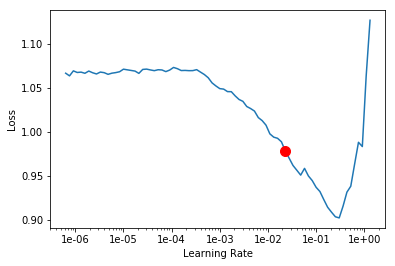

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
alpha = 1e-2
learn.fit_one_cycle(1, alpha, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.654109,0.524656,0.790301,00:08


In [15]:
learn.save('first')
learn.load('first');

From here on, we start to gradually unfreeze the layers and re-train the network, following the findings of the paper.

In [16]:
learn.freeze_to(-2)
alpha /= 2
learn.fit_one_cycle(1, slice(alpha/(2.6**4),alpha), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.614223,0.486181,0.813525,00:09


In [17]:
learn.save('second')
learn.load('second');

In [18]:
learn.freeze_to(-3)
alpha /= 2
learn.fit_one_cycle(1, slice(alpha/(2.6**4),alpha), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.571392,0.455563,0.829235,00:17


In [19]:
learn.save('third')
learn.load('third');

In [20]:
learn.unfreeze()
alpha /= 5
learn.fit_one_cycle(2, slice(alpha/(2.6**4),alpha), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.488669,0.453061,0.825137,00:23
1,0.476252,0.452318,0.825820,00:21


Let's save the final model for quicker future use.

In [21]:
learn.save('final')

## Checking results

In [22]:
if learn is None:
    learn = initialize_text_classifier()
learn.load('final');

In [23]:
score_train = learn.validate(data_clas.train_dl)[1].item()
score_test = learn.validate(data_clas.valid_dl)[1].item()

print("Train score = %f, test score = %f" % (score_train, score_test))

Train score = 0.878498, test score = 0.825820


Let's interpret the results some more. We can get the confusion matrix and the "most confused" samples:

In [24]:
interp = TextClassificationInterpretation.from_learner(learn)

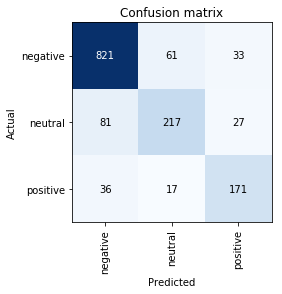

In [25]:
interp.plot_confusion_matrix()

In [26]:
interp.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj flight attendant xxunk provided excellent service among xxunk conditions throughout the day ✈ :-),positive,positive,10.09,1.00
xxbos you can do better than this . xxmaj and you can do better for me and all the passengers . # xxunk jfk to pwm .,negative,negative,4.68,0.98
xxbos i 'm xxunk for a good reason : you rock ! !,negative,positive,4.39,0.01
"xxbos xxmaj late xxmaj flight to xxmaj denver , xxmaj late xxmaj flight to xxmaj newark ... let 's not even get into the disaster that was checking bags . xxmaj unacceptable .",positive,negative,4.39,0.02
xxbos xxmaj you must follow me in order for me to send you a direct message if that is what you meant .,positive,neutral,4.29,0.01


But this is not so informative, so I made a small modification to just show the ones with misclassified labels :-)

In [27]:
my_utils.show_top_losses_misclassified(interp, 5)

Text,Prediction,Actual,Loss,Probability
xxbos i 'm xxunk for a good reason : you rock ! !,negative,positive,4.39,0.01
"xxbos xxmaj late xxmaj flight to xxmaj denver , xxmaj late xxmaj flight to xxmaj newark ... let 's not even get into the disaster that was checking bags . xxmaj unacceptable .",positive,negative,4.39,0.02
xxbos xxmaj you must follow me in order for me to send you a direct message if that is what you meant .,positive,neutral,4.29,0.01
xxbos yes to three different xxunk along the walk to the plane . xxmaj xxunk,positive,negative,4.18,0.06
xxbos i am a premium xxunk xxunk . xxmaj unacceptable 4 you to hangup my customerservice call twice after putting me on hold .,positive,negative,4.15,0.02


Let's show the predicted sentiment of some hand-made inputs:

In [33]:
examples = [
    "Awful flight",
    "Great trip, thanks to all",
    "attendant was rude!",
    "I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!",
    "first time with you, pretty fair :-) Food was ok"
]

for example in examples:
    pred = learn.predict(example)
    label = pred[0]
    probs = pred[2].tolist()
    print('\t'.join([str(label), '  '.join('%.3f' % p for p in probs), example]))

negative	0.961  0.003  0.036	Awful flight
positive	0.002  0.002  0.996	Great trip, thanks to all
positive	0.260  0.025  0.714	attendant was rude!
negative	0.667  0.101  0.232	I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!
positive	0.304  0.115  0.581	first time with you, pretty fair :-) Food was ok


Let's see which words of our examples had the greatest contribution in the classification decision:

In [34]:
import matplotlib.cm as cm

for example in examples:
    interp.show_intrinsic_attention(example, cmap=cm.Reds)

We can do the same with some random training examples:

In [35]:
df_sample = df_labeled.sample(5)

for _, row in df_sample.iterrows():
    interp.show_intrinsic_attention(row.text, cmap=cm.Reds)

## Putting all together

Finally, we can compare with some baseline results.

In [37]:
results = {}
results['ulmfit_wt103'] = (score_train, score_test)

Let's try with the trivial case (at random following prior class distributions):

In [41]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(df_labeled['text'], df_labeled['sentiment'], test_size=0.1, random_state=0)

print("Training size: %d; test size: %d" % (len(text_train), len(text_test)))

Training size: 13176; test size: 1464


In [45]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='stratified', random_state=42)
clf.fit(text_train, label_train)

score_train = clf.score(text_train, label_train)
score_test = clf.score(text_test, label_test)

results['random_with_class_dist'] = (score_train, score_test)

Let's also compare with the Multinominal NB, that performed well before and is fast to train.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer()
X_train = counter.fit_transform(text_train)
X_test = counter.transform(text_test)

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, label_train)

score_train = clf.score(X_train, label_train)
score_test = clf.score(X_test, label_test)

results['nb_multi_counts'] = (score_train, score_test)

In [51]:
results_df = pd.DataFrame([(k, *v) for k, v in results.items()], columns=['method', 'score_train', 'score_test'])
results_df = results_df.sort_values(by='score_test', ascending=False)
results_df

,method,score_train,score_test
0,ulmfit_wt103,0.878498,0.825820
2,nb_multi_counts,0.853673,0.767077
1,random_with_class_dist,0.464253,0.476093


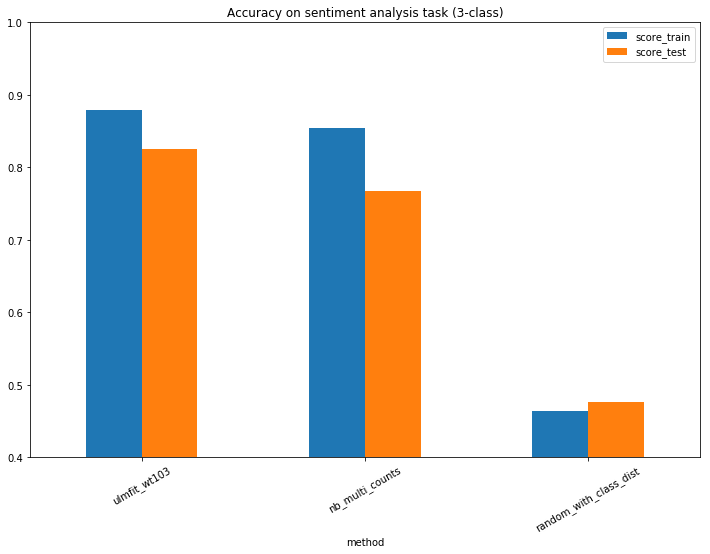

In [53]:
results_df.plot.bar(x='method', rot=30, ylim=(0.4, 1.0), figsize=(12, 8), title='Accuracy on sentiment analysis task (3-class)')

In [40]:
with open('data/results3.pkl', 'wb') as f:
    pickle.dump(results, f)